In [1]:
using GpABC, DifferentialEquations, Distances, Plots

# Rejection ABC using GaussProABC - estimating parameters

This notebook demonstrates how to perform simulation- and emulation-based rejection ABC using GaussProABC for parameter estimation of an ODE model.

Start by choosing some settings for ABC, the emulator and the toy, noise-free ODE system. There is also a wrapper function that returns the solution to the toy system for some given parameters and ODE solution options.

In [2]:
#
# ABC settings
#
n_var_params = 3
n_particles = 1000
threshold = 0.5
priors = [Distributions.Uniform(0., 5.), Distributions.Uniform(0., 5.), Distributions.Uniform(0., 30.)]
priors = priors[1:n_var_params]
distance_metric = euclidean
progress_every = 10000

#
# Emulation settings
#
n_design_points = 100
batch_size = 1000
max_iter = 1000

#
# True parameters
#
true_params =  [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]

#
# ODE solver settings
#
Tspan = (0.0, 10.0)
x0 = [3.0, 2.0, 1.0]
solver = RK4()
saveat = 0.1

#
# Returns the solution to the toy model as solved by DifferentialEquations
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1] = par[1]/(1+par[7]*x[3]) - par[4]*x[1]
    dx[2] = par[2]*par[8]*x[1]./(1+par[8]*x[1]) - par[5]*x[2]
    dx[3] = par[3]*par[9]*x[1]*par[10]*x[2]./(1+par[9]*x[1])./(1+par[10]*x[2]) - par[6]*x[3]
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

simulator_function(var_params) = GeneReg(vcat(var_params, true_params[n_var_params+1:end]), Tspan, x0, solver, saveat)

simulator_function (generic function with 1 method)

## Plot reference data

The reference data is the concentrations over time for the three species. Computed by solving the model with the true parameters.

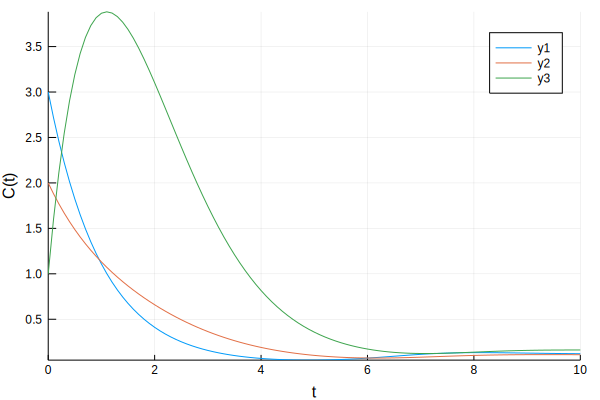

In [3]:
#
# Get reference data and plot it
#
reference_data = simulator_function(true_params[1:n_var_params])

println("Got reference data")
plot(reference_data.t, transpose(hcat(reference_data.u...)), xlabel="t", ylabel="C(t)")


## Simulation-based rejection ABC

To perform rejection ABC, first construct an instance of one of either two objects: `SimulatedABCRejectionInput` or `EmulatedABCRejectionInput`.

The simulated version contains the number of accepted particles, acceptance threshold, priors, the distance metric and the simulator funciton. Note that this needs to be extended to include summary statistics.

The simulator function is user-defined and must to take the unknown parameters as a single argument and return the simluated trajectories.

After constructing the input object it is passed to `ABCrejection` with the reference (observed) data to perform rejection ABC.

In [ ]:
#
# Simulation
#


sim_rej_input = SimulatedABCRejectionInput(n_var_params,
                        n_particles,
                        threshold,
                        priors,
                        "keep_all",
                        distance_metric,
                        simulator_function)

sim_result = ABCrejection(sim_rej_input, reference_data, progress_every=progress_every)

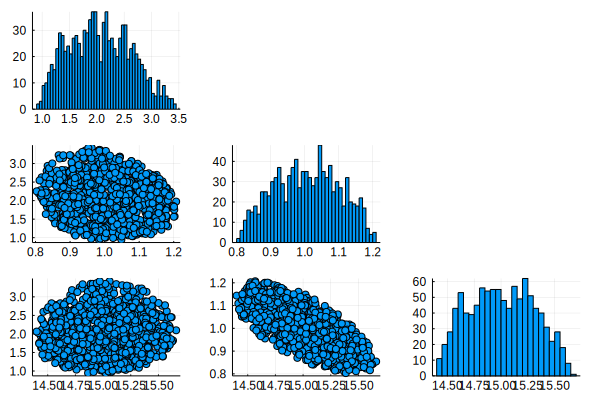

In [6]:
plot(sim_result)

## Emulation-based Rejection ABC

First train the emulator. This requires training inputs `X` and training outputs `y`, where `X` is an array with size (n_design_points, n_unknown_parameters) and `y` is an array with size (n_design_points).

The function `get_training_data` returns `X` and `y` in the correct format to be used with a `GPModel`.

Then train the model, plotting the design points and their distances.

Trained emulator


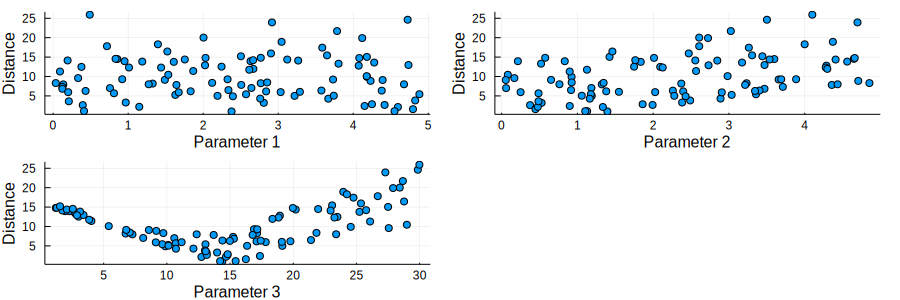

In [11]:
#
# Train the Emulator
#

#
# First prepare data for emulator - matrix X contains design ponts and y contains distances
#
function get_training_data(n_design_points,
  priors,
  simulator_function, distance_metric,
  reference_data)
    
  X = zeros(n_design_points, length(priors))
  y = zeros(n_design_points)  
  for i in 1:n_design_points
    dp = [rand(d) for d in priors]
    X[i,:] = dp
    y[i] = distance_metric(simulator_function(dp), reference_data)
  end
    
  return X, y
end

X, y = get_training_data(n_design_points, priors, simulator_function, distance_metric, reference_data)

#
# Train emulator - VARIANCE SEEMS SMALL
#
gpem = GPModel(training_x=X, training_y=y, kernel=SquaredExponentialArdKernel())
gp_train(gpem)

println("Trained emulator")

#
# Plot design points
#
plts = [scatter(X[:,idx], y, label="training data", xlabel="Parameter $idx", ylabel="Distance", legend=false) for idx = 1:n_var_params]
plot(plts..., size=(900, 300))

The second parameter is easier to pick up using this distance metric and summary statistic than the first.

When creating an `EmulatedABCRejectionInput` object provide a function that returns the emulated distances rather than the `simulator_function` required in the simulation case. Also provide a batch size and a maximum number of iterations.

In [14]:
#
# Use the emulator for rejection ABC
#
function predict_distance(p::AbstractArray{Float64})
    result = gp_regression(p,gpem)[1]
    return result
end

emu_rej_input = EmulatedABCRejectionInput(n_var_params,  
  n_particles,
  1.0,
  priors,     
  predict_distance,
  batch_size,
  max_iter)

emu_result = ABCrejection(emu_rej_input, reference_data, progress_every=100)

2018-06-25T12:03:23.243 Accepted 0/100000 particles (100 batches of size 1000).
2018-06-25T12:03:24.124 Accepted 0/200000 particles (200 batches of size 1000).
2018-06-25T12:03:24.983 Accepted 0/300000 particles (300 batches of size 1000).
2018-06-25T12:03:25.846 Accepted 0/400000 particles (400 batches of size 1000).
2018-06-25T12:03:26.718 Accepted 0/500000 particles (500 batches of size 1000).
2018-06-25T12:03:27.575 Accepted 0/600000 particles (600 batches of size 1000).
2018-06-25T12:03:28.455 Accepted 0/700000 particles (700 batches of size 1000).
2018-06-25T12:03:29.334 Accepted 0/800000 particles (800 batches of size 1000).
2018-06-25T12:03:30.209 Accepted 0/900000 particles (900 batches of size 1000).
2018-06-25T12:03:31.069 Accepted 0/1000000 particles (1000 batches of size 1000).


GpABC.ABCRejectionOutput(3, 0, 1000000, 1.0, Array{Float64}(0,3), Float64[], Float64[])

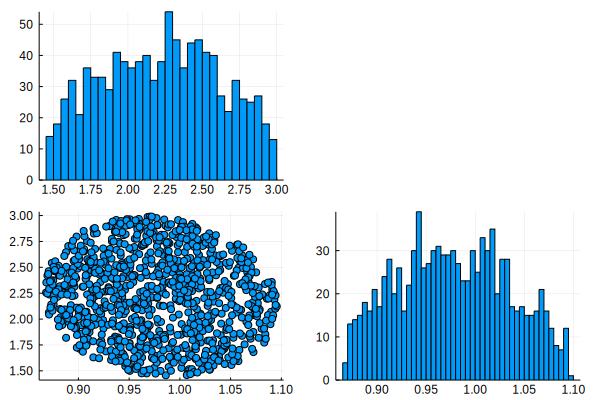

In [14]:
plot(emu_result)

# Comparing the resulting posteriors from simulation and emulation

They are similar and both center on the correct parameter values.

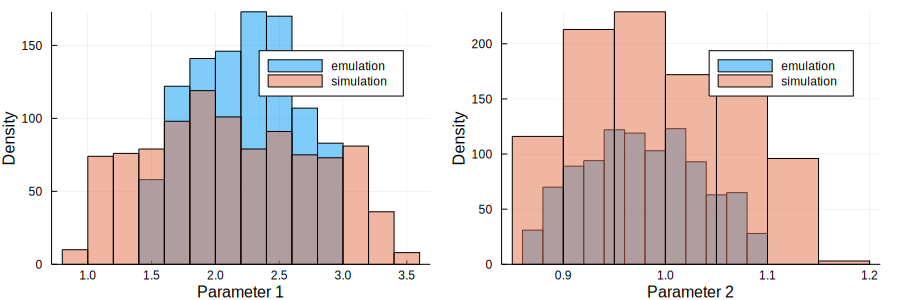

In [8]:
plts = Vector{Plots.Plot}(n_var_params)
for idx in 1:n_var_params
    plts[idx] = histogram([emu_result.population[:,idx] sim_result.population[:,idx]], 
        label=["emulation", "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density")
end
plot(plts..., size=(900,300))

# ABC-SMC

In [4]:
#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0]

3-element Array{Float64,1}:
 3.0
 2.0
 1.0

## Simulation-based ABC-SMC

In [5]:
sim_abcsmc_input = SimulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    "keep_all",
    distance_metric,
    simulator_function)

sim_abcsmc_res = ABCSMC(sim_abcsmc_input, reference_data)

2018-06-25T12:14:40.272 Accepted 64/1000 particles.
2018-06-25T12:14:40.399 Accepted 133/2000 particles.
2018-06-25T12:14:40.509 Accepted 189/3000 particles.
2018-06-25T12:14:40.619 Accepted 248/4000 particles.
2018-06-25T12:14:40.73 Accepted 321/5000 particles.
2018-06-25T12:14:40.839 Accepted 387/6000 particles.
2018-06-25T12:14:40.945 Accepted 452/7000 particles.
2018-06-25T12:14:41.054 Accepted 514/8000 particles.
2018-06-25T12:14:41.17 Accepted 578/9000 particles.
2018-06-25T12:14:41.305 Accepted 632/10000 particles.
2018-06-25T12:14:41.44 Accepted 703/11000 particles.
2018-06-25T12:14:41.561 Accepted 784/12000 particles.
2018-06-25T12:14:41.674 Accepted 850/13000 particles.
2018-06-25T12:14:41.787 Accepted 914/14000 particles.
2018-06-25T12:14:41.899 Accepted 976/15000 particles.
2018-06-25T12:14:43.462 Accepted 234/1000 particles.
2018-06-25T12:14:44.083 Accepted 484/2000 particles.
2018-06-25T12:14:44.707 Accepted 682/3000 particles.
2018-06-25T12:14:45.329 Accepted 914/4000 pa

GpABC.ABCSMCOutput(3, [1000, 1000, 1000], [15366, 4387, 9636], [3.0, 2.0, 1.0], Array{Float64,2}[[3.61197 1.64701 14.6568; 0.298517 0.20852 16.1848; … ; 2.81744 0.851193 16.7281; 2.95309 1.3436 16.5355], [0.775756 1.19724 13.5786; 4.77907 0.634018 15.6664; … ; 4.3054 0.533404 14.8396; 4.49405 0.497065 16.6712], [1.91224 1.29613 14.2875; 0.724888 1.0737 15.4211; … ; 1.39487 1.06217 14.1111; 1.35421 0.916185 15.7345]], Array{Float64,1}[[2.04529, 2.59826, 1.82636, 1.64159, 0.714881, 1.73506, 2.73013, 2.2077, 2.62304, 2.81513  …  2.18792, 2.22706, 0.662337, 2.66268, 2.04736, 2.34253, 2.50474, 1.15326, 1.52371, 2.66982], [1.33327, 1.14684, 1.54885, 1.36618, 1.87196, 0.981386, 0.942104, 0.984104, 0.927022, 1.46682  …  1.35367, 0.651179, 1.59783, 1.72907, 0.981403, 1.86796, 1.13844, 1.2287, 1.81419, 1.48769], [0.718269, 0.830173, 0.463547, 0.267164, 0.772749, 0.825352, 0.77643, 0.658126, 0.536549, 0.928764  …  0.781861, 0.611274, 0.60829, 0.850896, 0.97098, 0.383884, 0.420588, 0.562236, 0.869

In [6]:
plot(sim_abcsmc_res)

## Emulation-based ABC-SMC

In [11]:
emu_abcsmc_input = EmulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    predict_distance,
    batch_size,
    max_iter)

emu_abcsmc_res = ABCSMC(emu_abcsmc_input, reference_data)

2018-06-24T22:48:47.802 Accepted 602/1000 particles.
2018-06-24T22:48:48.916 Accepted 415/1000 particles.
2018-06-24T22:48:49.558 Accepted 836/2000 particles.


GpABC.ABCSMCOutput(2, [1000, 1000, 1000], [3000, 1626, 2403], [3.0, 2.0, 1.0], Array{Float64,2}[[0.393351 1.54676; 4.33872 0.612409; … ; 1.07845 1.88113; 3.23585 0.834285], [3.47416 0.626363; 1.01276 0.896397; … ; 2.69475 1.06393; 3.467 0.922886], [2.30624 1.00497; 3.48238 1.08355; … ; 2.53292 0.972207; 2.48713 0.964826]], Array{Float64,1}[[1.79862, 1.49941, 1.67377, 2.84166, 2.79686, 0.849909, 0.623375, 0.585076, 1.4541, 2.83227  …  2.27139, 2.84395, 0.559639, 2.82559, 1.08361, 0.949071, 1.23059, 2.21312, 2.68548, 0.643785], [1.22666, 0.666766, 0.74276, 0.663623, 1.60767, 0.968349, 1.48788, 0.64457, 1.78205, 0.994185  …  1.79132, 0.665036, 1.84312, 0.807603, 1.79169, 0.616222, 1.62613, 0.828615, 0.501708, 0.613202], [0.433169, 0.684201, 0.987208, 0.571039, 0.782987, 0.838921, 0.661249, 0.974113, 0.440878, 0.935746  …  0.668443, 0.536938, 0.813537, 0.73387, 0.76004, 0.633602, 0.64754, 0.858914, 0.440663, 0.437868]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.

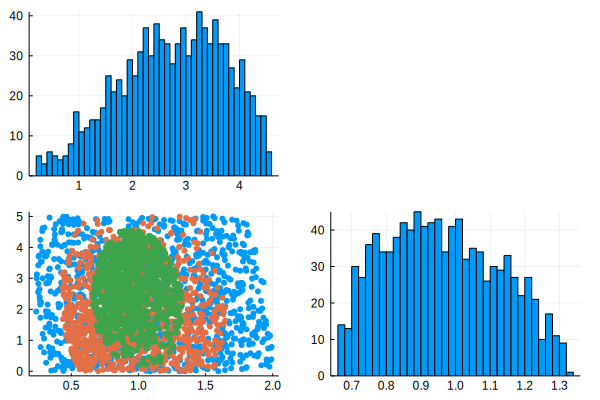

In [27]:
plot(emu_abcsmc_res, markerstrokecolor=false)

## Compare the posteriors

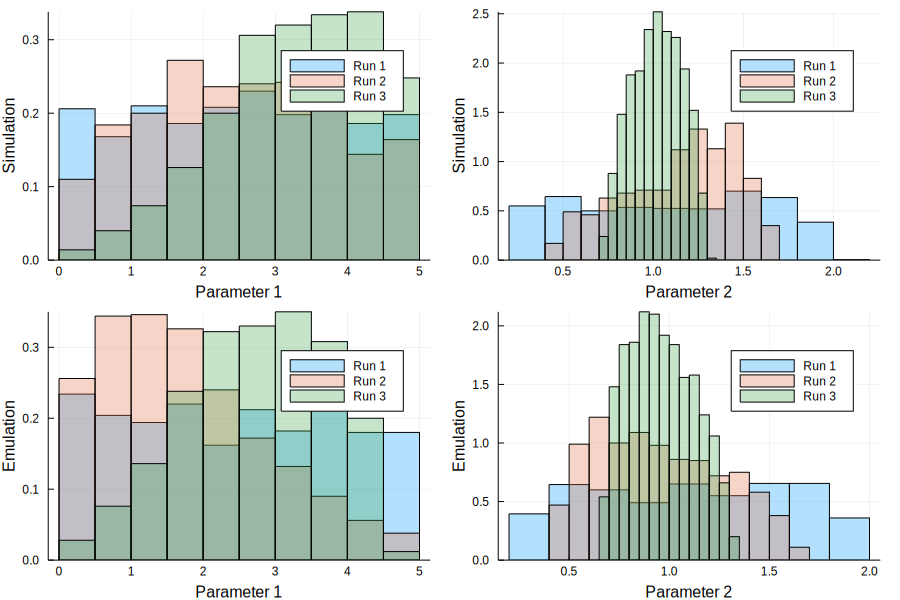

In [21]:
abcsmc_res = [sim_abcsmc_res, emu_abcsmc_res]
ylabels=["Simulation", "Emulation"]
plts = Vector{Plots.Plot}(n_var_params * 2)
idx = 1
for i in 1:2
    for j in 1:n_var_params
        hist_data = hcat([abcsmc_res[i].population[k][:,j] for k in 1:length(threshold_schedule)]...)
        labels = ["Run $k" for k in 1:length(threshold_schedule)]
        plts[idx] = histogram(hist_data, label=labels, fillalpha=0.3, 
            xlabel="Parameter $j", ylabel=ylabels[i], normed=true)
        idx += 1
    end
end
plot(plts..., size=(900,600))


In [13]:
size(abcsmc_res[1].population[end])

LoadError: [91mUndefVarError: abcsmc_res not defined[39m